# Advanced composition patterns - pipelines, reduction, autoML
---

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install sktime[forecasting] # may take a while

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.5/983.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.9/974.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.5/403.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## advanced composition patterns to create forecasters out of simpler components

- Reduction - building a forecaster from estimators of “simpler” scientific types, like scikit-learn regressors. A common example is feature/label tabulation by rolling window, aka the “direct reduction strategy”.

- Tuning - determining values for hyper-parameters of a forecaster in a data-driven manner. A common example is grid search on temporally rolling re-sampling of train/test splits.

- Pipelining - concatenating transformers with a forecaster to obtain one forecaster. A common example is detrending and deseasonalizing then forecasting, an instance of this is the common “STL forecaster”.

AutoML, also known as automated model selection - using automated tuning strategies to select not only hyper-parameters but entire forecasting strategies. A common example is on-line multiplexer tuning.

In [3]:
# imports necessary for this chapter
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

# data loading for illustration (see section 1 for explanation)
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64


## a meta-estimator
sktime provides a meta-estimator that allows the use of any scikit-learn estimator for forecasting.

- modular and compatible with scikit-learn, so that we can easily apply any scikit-learn regressor to solve our forecasting problem,

- parametric and tuneable, allowing us to tune hyper-parameters such as the window length or strategy to generate forecasts

- adaptive, in the sense that it adapts the scikit-learn’s estimator interface to that of a forecaster, making sure that we can tune and properly evaluate our model

**Example**: we will define a tabulation reduction strategy to convert a k-nearest neighbors regressor (sklearn KNeighborsRegressor) into a forecaster. The composite algorithm is an object compliant with the sktime forecaster interface (picture: big robot), and contains the regressor as a parameter accessible component (picture: little robot). In fit, the composite algorithm uses a sliding window strategy to tabulate the data, and fit the regressor to the tabulated data (picture: left half). In predict, the composite algorithm presents the regressor with the last observed window to obtain predictions (picture: right half).

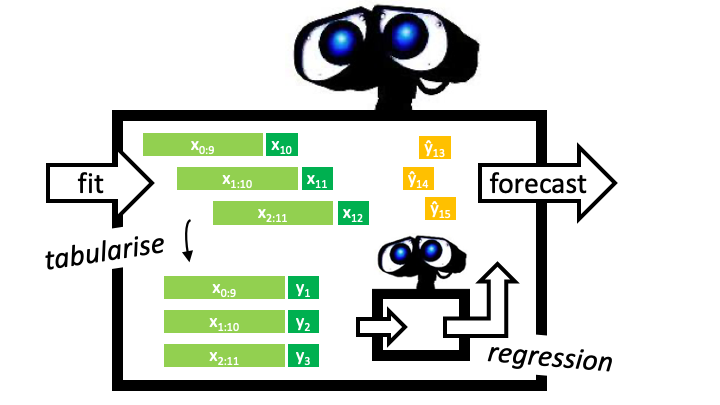![image.png](
    
)

Below, the composite is constructed using the shorthand function `make_reduction` which produces a sktime estimator of forecaster scitype. It is called with a constructed `scikit-learn` regressor, regressor, and additional parameter which can be later tuned as hyper-parameters

In [4]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction

np.float64(0.12887507224382988)

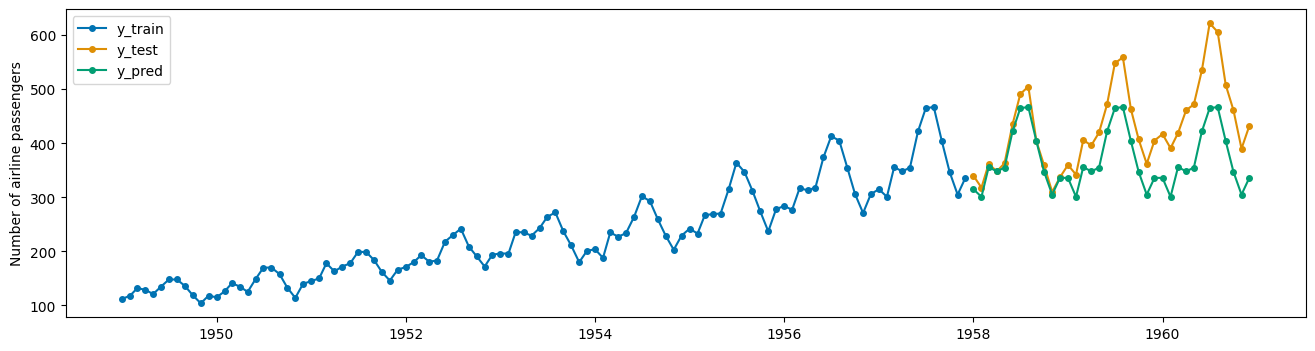

In [ ]:
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In the above example we use the “recursive” reduction strategy. Other implemented strategies are:

“direct”, “dirrec”, “multioutput”.

Parameters can be inspected using scikit-learn compatible `get_params` functionality (and set using `set_params`). This provides tunable and nested access to parameters of the KNeighborsRegressor (as estimator_etc), and the window_length of the reduction strategy. Note that the strategy is not accessible, as underneath the utility function this is mapped on separate algorithm classes. For tuning over algorithms, see the “autoML” section below.

In [ ]:
forecaster.get_params()

{'estimator': KNeighborsRegressor(n_neighbors=1),
 'pooling': 'local',
 'transformers': None,
 'window_length': 15,
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 1,
 'estimator__p': 2,
 'estimator__weights': 'uniform'}

## The basic forecasting pipeline
---

sktime provides a generic pipeline object for this kind of composite modelling, the TransformedTargetForecaster. It chains an arbitrary number of transformations with a forecaster. The transformations can either be pre-processing transformations or a post-processing transformations. An example of a forecaster with pre-processing transformations can be seen below.

In [ ]:
!pip install statsforecast>=1.0.0

In [ ]:
# from sktime.forecasting.arima import ARIMA
# import statsforecast

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

np.float64(0.056544182846301964)

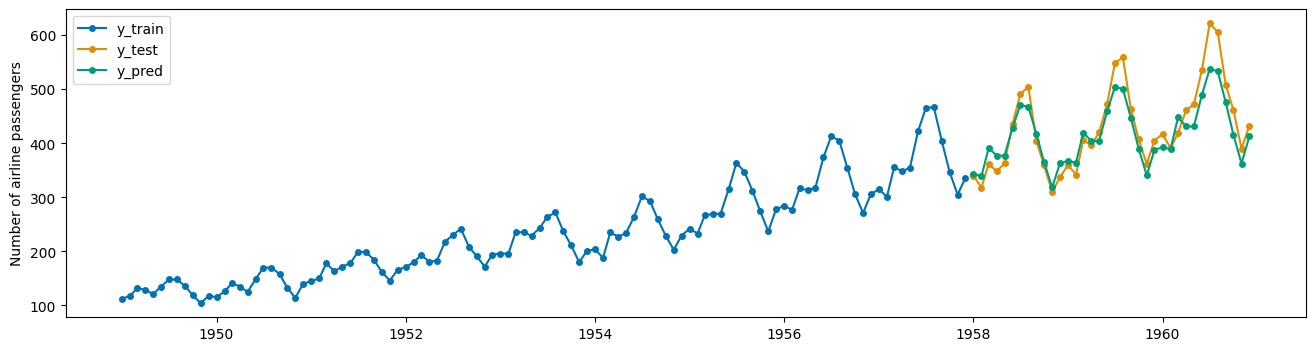

In [ ]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("forecast", StatsForecastAutoARIMA()),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In the above example, the TransformedTargetForecaster is constructed with a list of steps, each a pair of name and estimator, where the last estimator is a forecaster scitype.

- The pre-processing transformers should be series-to-series transformers which possess both a transform and an inverse_transform method.

- The resulting estimator is of forecaster scitype and has all interface defining methods.

In fit, all transformers apply fit_transforms to the data, then the forecaster’s fit; in predict, first the forecaster’s predict is applied, then the transformers’ inverse_transform in reverse order.

The same pipeline, as above, can also be constructed with the multiplication dunder method *.

This creates a TransformedTargetForecaster as above, with components given default names.

In [ ]:
forecaster = Deseasonalizer(model="multiplicative", sp=12) * StatsForecastAutoARIMA()
forecaster

TransformedTargetForecaster(steps=[Deseasonalizer(model='multiplicative',
                                                  sp=12),
                                   StatsForecastAutoARIMA()])

In [ ]:
# Example of a multiple seasonality model:

forecaster = (
    Deseasonalizer(model="multiplicative", sp=12)
    * Deseasonalizer(model="multiplicative", sp=3)
    * StatsForecastAutoARIMA()
)

forecaster.get_params()

{'steps': [Deseasonalizer(model='multiplicative', sp=12),
  Deseasonalizer(model='multiplicative', sp=3),
  StatsForecastAutoARIMA()],
 'Deseasonalizer_1': Deseasonalizer(model='multiplicative', sp=12),
 'Deseasonalizer_2': Deseasonalizer(model='multiplicative', sp=3),
 'StatsForecastAutoARIMA': StatsForecastAutoARIMA(),
 'Deseasonalizer_1__model': 'multiplicative',
 'Deseasonalizer_1__sp': 12,
 'Deseasonalizer_2__model': 'multiplicative',
 'Deseasonalizer_2__sp': 3,
 'StatsForecastAutoARIMA__D': None,
 'StatsForecastAutoARIMA__approximation': None,
 'StatsForecastAutoARIMA__biasadj': False,
 'StatsForecastAutoARIMA__blambda': None,
 'StatsForecastAutoARIMA__d': None,
 'StatsForecastAutoARIMA__information_criterion': 'aicc',
 'StatsForecastAutoARIMA__max_D': 1,
 'StatsForecastAutoARIMA__max_P': 2,
 'StatsForecastAutoARIMA__max_Q': 2,
 'StatsForecastAutoARIMA__max_d': 2,
 'StatsForecastAutoARIMA__max_order': 5,
 'StatsForecastAutoARIMA__max_p': 5,
 'StatsForecastAutoARIMA__max_q': 5,
 '

We can also create a pipeline with post-processing transformations, these are transformations after the forecaster, in a dunder pipeline or a TransformedTargetForecaster.

Below is an example of a multiple seasonality model, with integer rounding post-processing of the predictions:

In [ ]:
from sktime.transformations.series.func_transform import FunctionTransformer

forecaster = StatsForecastAutoARIMA() * FunctionTransformer(lambda y: y.round())
forecaster.fit_predict(y, fh=fh).head(3)

,Number of airline passengers
Period,
1958-01,370.0
1958-02,357.0
1958-03,330.0


Both pre- and post-processing transformers can be present, in this case the post-processing transformations will be applied after the inverse-transform of the pre-processing ones.

In [ ]:
forecaster = (
    Deseasonalizer(model="multiplicative", sp=12)
    * Deseasonalizer(model="multiplicative", sp=3)
    * StatsForecastAutoARIMA()
    * FunctionTransformer(lambda y: y.round())
)

forecaster.fit_predict(y_train, fh=fh).head(3)

,Number of airline passengers
Period,
1958-01,344.0
1958-02,340.0
1958-03,391.0


np.float64(0.05641541230083084)

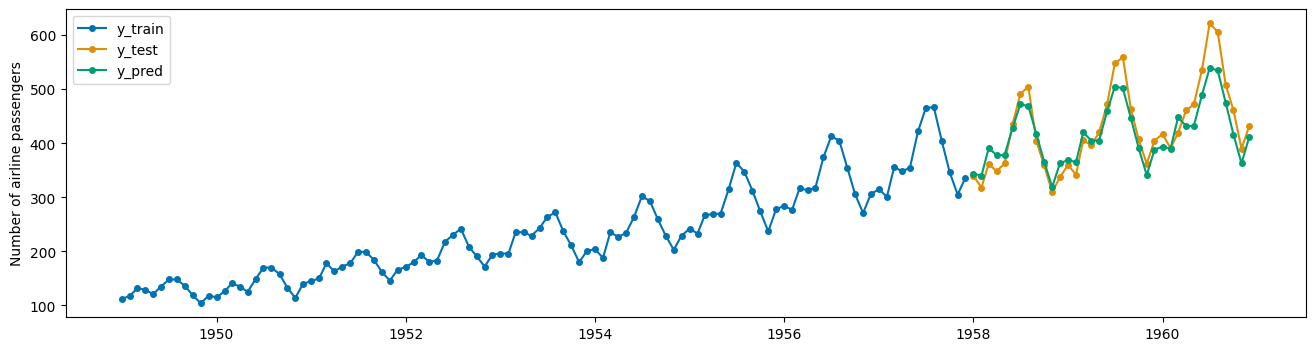

In [ ]:
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

### The Detrender as pipeline component
---

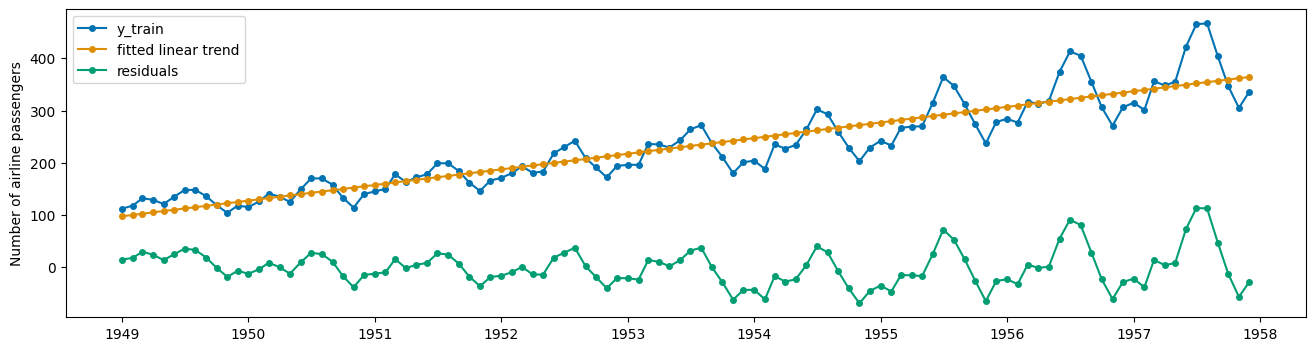

In [ ]:
import numpy as np

from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender

# linear detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions
# of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train))  # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_series(
    y_train, y_pred, yt, labels=["y_train", "fitted linear trend", "residuals"]
);

np.float64(0.052768289012939645)

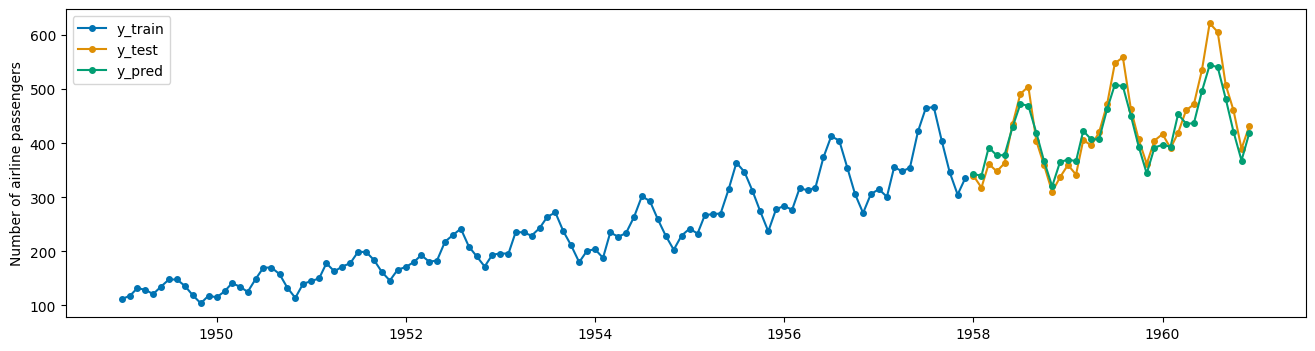

In [ ]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", StatsForecastAutoARIMA()),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

## Tunning
---
sktime provides parameter tuning strategies as compositors of forecaster scitype, similar to scikit-learn’s GridSearchCV.

### ForecastingGridSearchCV
---
The compositor ForecastingGridSearchCV (and other tuners) are constructed with a forecaster to tune, a cross-validation constructor, a scikit-learn parameter grid, and parameters specific to the tuning strategy. Cross-validation constructors follow the scikit-learn interface for re-samplers, and can be slotted in exchangeably.

As an example, we show tuning of the window length in the reduction compositor from Section 3.1, using temporal sliding window tuning:

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.split import SlidingWindowSplitter
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [7, 12, 15]}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)

As with other composites, the resulting forecaster provides the unified interface of sktime forecasters - window splitting, tuning, etc requires no manual effort and is done behind the unified interface:

np.float64(0.16607972017556033)

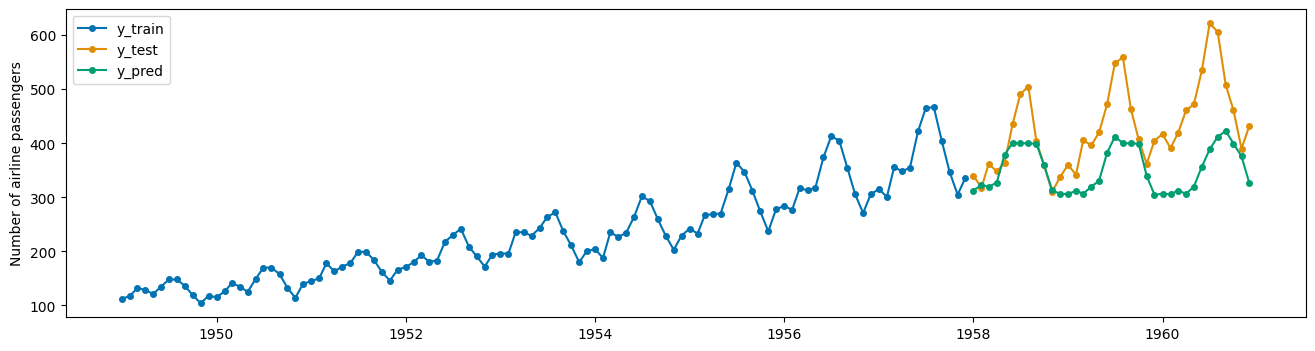

In [ ]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
gscv.best_params_

{'window_length': 7}

In [ ]:
# An instance of the best forecaster, with hyper-parameters set,
# can be retrieved by accessing the best_forecaster_ attribute:
gscv.best_forecaster_

RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                     window_length=7)

For example, below we tune the KNeighborsRegressor component’s n_neighbors, in addition to tuning window_length. The tuneable parameters can easily be queried using forecaster.get_params().

np.float64(0.13988948769413537)

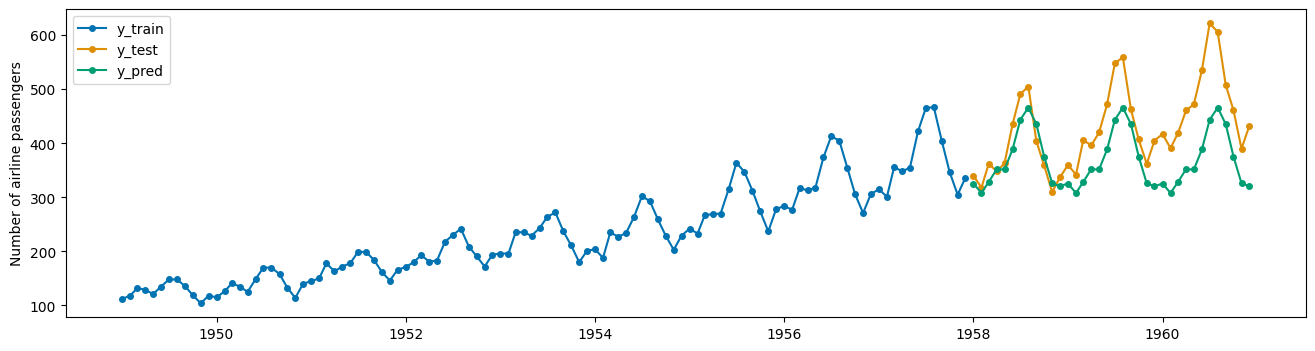

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.split import SlidingWindowSplitter
param_grid = {"window_length": [7, 12, 15], "estimator__n_neighbors": np.arange(1, 10)}

regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, strategy="recursive")

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=30)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
gscv.best_params_

{'estimator__n_neighbors': np.int64(2), 'window_length': 12}

### GridSearchCV
---
An alternative to the above is tuning the regressor separately, using scikit-learn’s GridSearchCV and a separate parameter grid. As this does not use the “overall” performance metric to tune the inner regressor, performance of the composite forecaster may vary.

np.float64(0.14493362646957736)

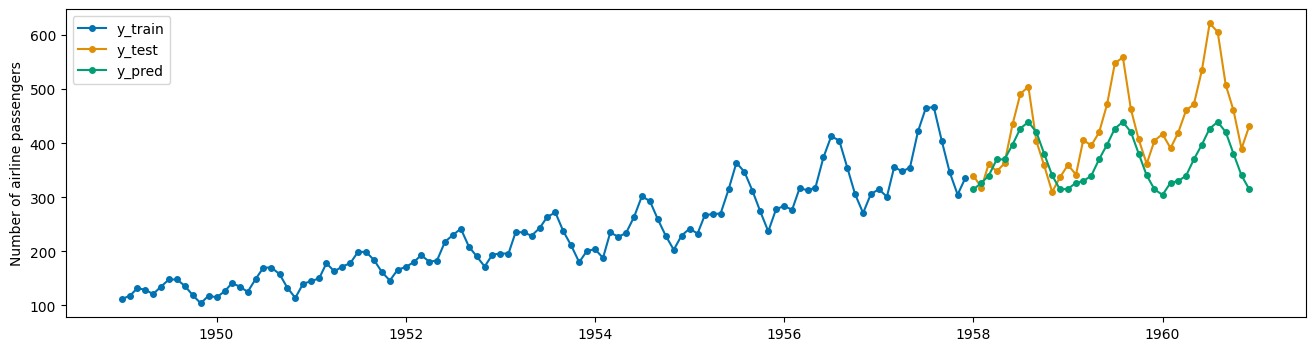

In [ ]:
from sklearn.model_selection import GridSearchCV

# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {"n_neighbors": np.arange(1, 10)}
forecaster_param_grid = {"window_length": [7, 12, 15]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(KNeighborsRegressor(), param_grid=regressor_param_grid)
forecaster = make_reduction(regressor, strategy="recursive")

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=30)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In the above example, using the mean squared error instead of the mean absolute percentage error for tuning would be done by defining the forecaster as follows:

In [ ]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()

param_grid = {"window_length": [7, 12, 15]}

regressor = KNeighborsRegressor()
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=30)

gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid, scoring=mse)

In [ ]:
gscv.fit(y_train)
gscv.cv_results_

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
0,2600.750255,0.150510,0.009122,{'window_length': 7},3.0
1,1134.999053,0.148025,0.010034,{'window_length': 12},1.0
2,1285.133614,0.091262,0.006526,{'window_length': 15},2.0


### MultiplexForecaster
The most flexible way to perform model selection over forecasters is by using the MultiplexForecaster, which exposes the choice of a forecaster from a list as a hyper-parameter that is tunable by generic hyper-parameter tuning strategies such as in Section 3.3.

In isolation, MultiplexForecaster is constructed with a named list forecasters, of forecasters. It has a single hyper-parameter, selected_forecaster, which can be set to the name of any forecaster in forecasters, and behaves exactly like the forecaster keyed in forecasters by selected_forecaster.

In [ ]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ],
)
forecaster.set_params(**{"selected_forecaster": "naive"})
# now forecaster behaves like NaiveForecaster(strategy="last")

MultiplexForecaster(forecasters=[('naive', NaiveForecaster()),
                                 ('ets',
                                  ExponentialSmoothing(sp=12, trend='add'))],
                    selected_forecaster='naive')

In [ ]:
forecaster.set_params(**{"selected_forecaster": "ets"})
# now forecaster behaves like ExponentialSmoothing(trend="add", sp=12))

MultiplexForecaster(forecasters=[('naive', NaiveForecaster()),
                                 ('ets',
                                  ExponentialSmoothing(sp=12, trend='add'))],
                    selected_forecaster='ets')

The MultiplexForecaster is not too useful in isolation, but allows for flexible autoML when combined with a tuning wrapper. The below defines a forecaster that selects one of NaiveForecaster and ExponentialSmoothing by sliding window tuning as in Section 3.3.

Combined with rolling use of the forecaster via the update functionality (see Section 1.4), the tuned multiplexer can switch back and forth between NaiveForecaster and ExponentialSmoothing, depending on performance, as time progresses.

np.float64(0.19886711926999853)

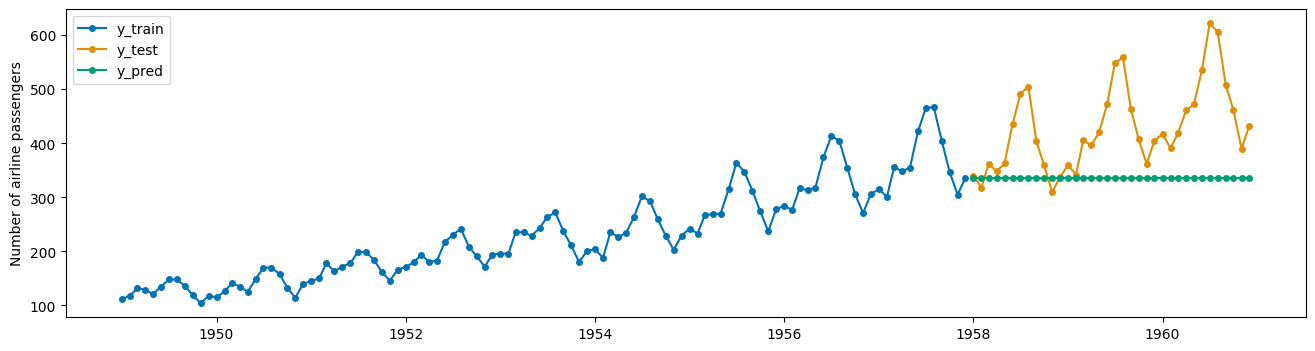

In [ ]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.split import SlidingWindowSplitter
forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ]
)
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5), window_length=30)
forecaster_param_grid = {"selected_forecaster": ["ets", "naive"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
gscv.best_params_
# {'selected_forecaster': 'naive'}
gscv.best_forecaster_

MultiplexForecaster(forecasters=[('naive', NaiveForecaster()),
                                 ('ets',
                                  ExponentialSmoothing(sp=12, trend='add'))],
                    selected_forecaster='naive')

### OptionalPassthrough
---
The OptionalPassthrough transformer allows to tune whether a transformer inside a pipeline is applied to the data or not. For example, if we want to tune whether sklearn.StandardScaler is bringing an advantage to the forecast or not, we wrap it in OptionalPassthrough. Internally, OptionalPassthrough has a hyperparameter passthrough: bool that is tuneable; when False the composite behaves like the wrapped transformer, when True, it ignores the transformer within.

To make effective use of OptionalPasstrhough, define a suitable parameter set using the __ (double underscore) notation familiar from scikit-learn. This allows to access and tune attributes of nested objects like TabularToSeriesAdaptor(StandardScaler()). We can use __ multiple times if we have more than two levels of nesting.

In the following example, we take a deseasonalize/scale pipeline and tune over the four possible combinations of deseasonalizer and scaler being included in the pipeline yes/no (2 times 2 = 4); as well as over the forecaster’s and the scaler’s parameters.

Note: this could be arbitrarily combined with MultiplexForecaster, as in Section 3.4.1, to select over pipeline architecture as well as over pipeline structure.

np.float64(0.1299046419013891)

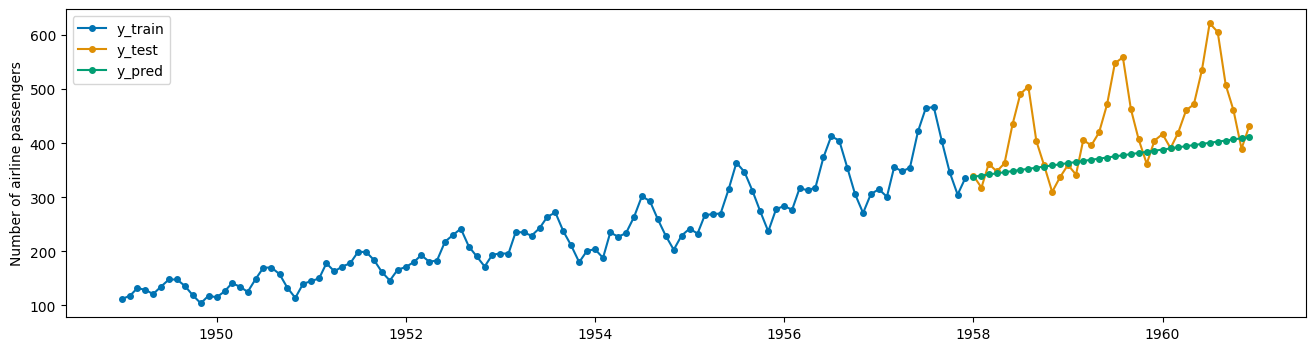

In [ ]:
from sklearn.preprocessing import StandardScaler

from sktime.datasets import load_airline
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.naive import NaiveForecaster
from sktime.split import SlidingWindowSplitter
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import Deseasonalizer
# create pipeline
pipe = TransformedTargetForecaster(
    steps=[
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(StandardScaler()))),
        ("forecaster", NaiveForecaster()),
    ]
)

# putting it all together in a grid search
cv = SlidingWindowSplitter(
    initial_window=60, window_length=24, start_with_window=True, step_length=24
)
param_grid = {
    "deseasonalizer__passthrough": [True, False],
    "scaler__transformer__transformer__with_mean": [True, False],
    "scaler__passthrough": [True, False],
    "forecaster__strategy": ["drift", "mean", "last"],
}
gscv = ForecastingGridSearchCV(forecaster=pipe, param_grid=param_grid, cv=cv)
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

### EnsembleForecaster

np.float64(0.1661796803565588)

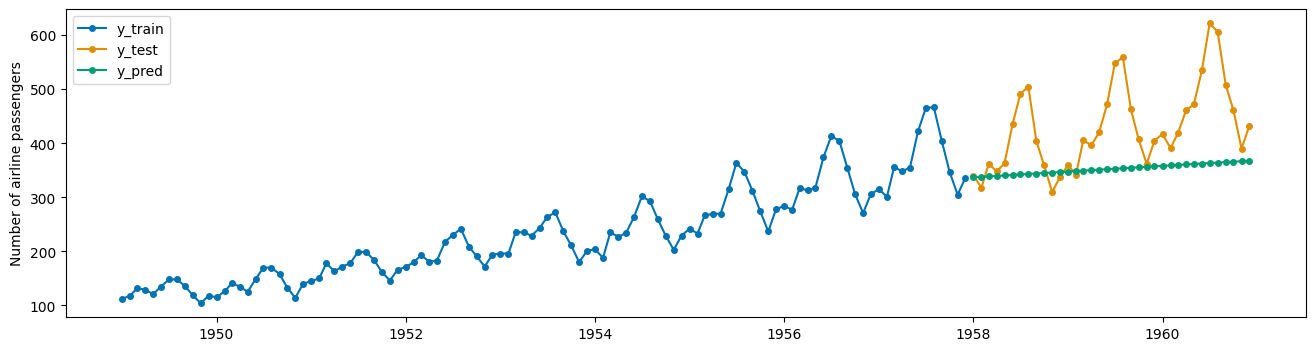

In [ ]:
from sktime.forecasting.compose import EnsembleForecaster
ses = ExponentialSmoothing(sp=12)
holt = ExponentialSmoothing(trend="add", damped_trend=False, sp=12)
damped = ExponentialSmoothing(trend="add", damped_trend=True, sp=12)

forecaster = EnsembleForecaster(
    [
        ("ses", ses),
        ("holt", holt),
        ("damped", damped),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

For model evaluation, we sometimes want to evaluate multiple forecasts, using temporal cross-validation with a sliding window over the test data. For this purpose, we can leverage the forecasters from the online_forecasting module which use a composite forecaster, PredictionWeightedEnsemble, to keep track of the loss accumulated by each forecaster and create a prediction weighted by the predictions of the most “accurate” forecasters.

Note that the forecasting task is changed: we make 35 predictions since we need the first prediction to help update the weights, we do not predict 36 steps ahead.

In [ ]:
from sktime.forecasting.all import mean_squared_error
from sktime.forecasting.online_learning import (
    NormalHedgeEnsemble,
    OnlineEnsembleForecaster,
)

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen

First we need to initialize a PredictionWeightedEnsembler that will keep track of the loss accumulated by each forecaster and define which loss function we would like to use.

In [ ]:
hedge_expert = NormalHedgeEnsemble(n_estimators=3, loss_func=mean_squared_error)

/usr/local/lib/python3.11/dist-packages/sktime/forecasting/base/_base.py:2175: UserWarning: NotImplementedWarning: ExponentialSmoothing does not have a custom `update` method implemented. ExponentialSmoothing will be refit each time `update` is called with update_params=True. To refit less often, use the wrappers in the forecasting.stream module, e.g., UpdateEvery.
  warn(
/usr/local/lib/python3.11/dist-packages/sktime/forecasting/base/_base.py:2175: UserWarning: NotImplementedWarning: ExponentialSmoothing does not have a custom `update` method implemented. ExponentialSmoothing will be refit each time `update` is called with update_params=True. To refit less often, use the wrappers in the forecasting.stream module, e.g., UpdateEvery.
  warn(
/usr/local/lib/python3.11/dist-packages/sktime/forecasting/base/_base.py:2175: UserWarning: NotImplementedWarning: ExponentialSmoothing does not have a custom `update` method implemented. ExponentialSmoothing will be refit each time `update` is cal

np.float64(0.0978975689038194)

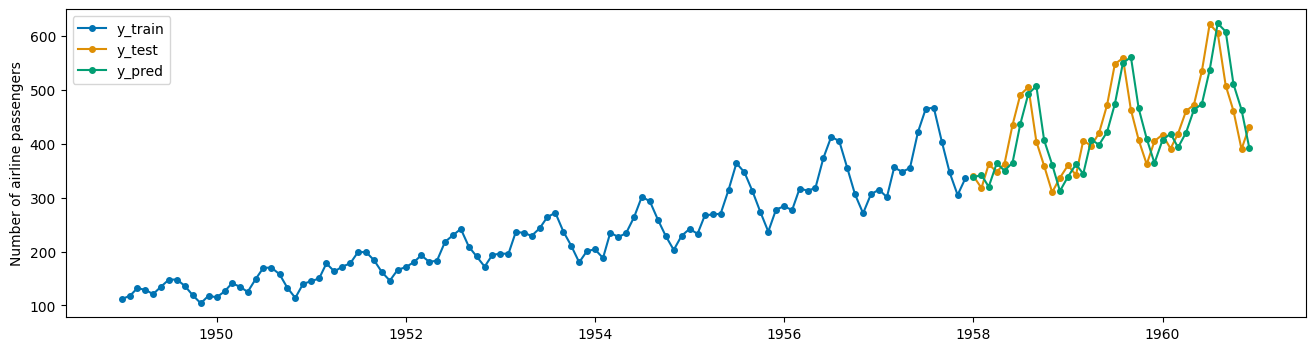

In [ ]:
forecaster = OnlineEnsembleForecaster(
    [
        ("ses", ses),
        ("holt", holt),
        ("damped", damped),
    ],
    ensemble_algorithm=hedge_expert,
)

forecaster.fit(y=y_train, fh=fh)
y_pred = forecaster.update_predict_single(y_test)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

## Постановка задачи
---
1. В качестве обучающей выборки берем курс с 2014 года до 2024 года не включая его
2. В качестве тестовой выборки рассматриваем остальные данные с начала 2024 года
3. Строим прогнозатор на 2 недели вперед и прогнозируем курс на год
4. В качестве прогнозатора используем минимум 3 различных конвейра (предобработка + ансамбль)
5. Используем GridSearchCV (или другой тюнер) для тюнинга метапараметров(точно размер окна и какие-то еще.......)
6. Обучаем ансамбль всевозможных прогнозаторов для прогноза. Сравниваем результаты прогнозирования
7. Сравниваем все построенные прогнозаторы по усредненной метрике MAPE и графически (строим графики сравнения тестового и прогнозируемого сигнала)


In [7]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Colab Notebooks/TimeSeriesPrediction/"

if 'google.colab' in str(get_ipython()):
    !pip install sktime[forecasting]
    data_location = path + "data/"
else:
    data_location = "../"

data_location

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/Colab Notebooks/TimeSeriesPrediction/data/'

In [9]:
import pandas as pd
raw_data = pd.read_csv(data_location + 'dollar-9.csv', header=0, sep=';', decimal=',', index_col=0, parse_dates=True)

raw_data.index = pd.to_datetime(raw_data.index, dayfirst=True)
raw_data.dollar = raw_data.dollar.str.replace(',', '.')
raw_data.dollar = pd.to_numeric(raw_data.dollar, errors='coerce')
raw_data.tail()

,dollar
datetime,
2025-01-23,98.2804
2025-01-24,99.0978
2025-01-25,98.2636
2025-01-28,97.1320
2025-01-29,97.9658


In [10]:
ts = raw_data.dollar
ts[:2], ts.index[:2]

(datetime
 2009-01-01    29.3916
 2009-01-12    30.5331
 Name: dollar, dtype: float64,
 DatetimeIndex(['2009-01-01', '2009-01-12'], dtype='datetime64[ns]', name='datetime', freq=None))

In [11]:
#добавляем пропущенные дни;
tiny_data = raw_data.resample('D').asfreq()
tiny_data = tiny_data.interpolate(method="linear", axis=0)
tiny_data.head()

,dollar
datetime,
2009-01-01,29.391600
2009-01-02,29.495373
2009-01-03,29.599145
2009-01-04,29.702918
2009-01-05,29.806691


In [ ]:
discret_degree = 'D'
ts = tiny_data.dollar
fill_ts = ts

startdate = pd.to_datetime('2013-01-01')  # начало периода анализа
enddate = pd.to_datetime('2024-01-29')  # завершение периода анализа

In [ ]:
import numpy as np

forecast_horizon = np.arange(1, 15)

In [ ]:
train_start = pd.to_datetime('2014-01-01')
train_end = pd.to_datetime('2023-12-31')
test_start = pd.to_datetime('2024-01-01')
test_end = pd.to_datetime('2025-01-29')

train_data = fill_ts[train_start:train_end].astype(float)
test_data = fill_ts[test_start:test_end].astype(float)

In [ ]:
print(train_data.shape)
print(test_data.shape)


(3652,)
(395,)


In [ ]:
window_size = 14

def rolling_forecast(model, train_init, test_data, window_size):
    y_pred = []
    history = train_init.copy()
    total_steps = len(test_data)

    for i in range(0, total_steps, window_size):
        remaining_days = total_steps - i
        current_window_size = min(window_size, remaining_days)

        fh = ForecastingHorizon(np.arange(1, current_window_size + 1), is_relative=True)
        model.fit(history)
        pred = model.predict(fh)
        y_pred.extend(pred)

        if i + current_window_size <= total_steps:
            history = pd.concat([history, test_data.iloc[i:i+current_window_size]])

    y_pred = y_pred[:total_steps]
    return pd.Series(y_pred, index=test_data.index[:total_steps])

In [ ]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

pipe1 = TransformedTargetForecaster([
    ("deseasonalize", Deseasonalizer(model="multiplicative", sp=30)),
    ("forecast", StatsForecastAutoARIMA())
])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

pipe2 = TransformedTargetForecaster([
    ("detrend", Detrender(PolynomialTrendForecaster(degree=1))),
    ("forecast", make_reduction(
        RandomForestRegressor(n_estimators=100),
        window_length=30,
        strategy="recursive"
    ))
])

In [ ]:
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

pipe3 = TransformedTargetForecaster([
    ("scaler", TabularToSeriesAdaptor(StandardScaler())),
    ("forecast", ExponentialSmoothing(trend="add", seasonal="additive", sp=30))
])

In [ ]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.split import SlidingWindowSplitter

cv = SlidingWindowSplitter(window_length=90, step_length=30)

param_grid_rf = {
    "forecast__estimator__n_estimators": [50, 100],
    "forecast__window_length": [14, 30]
}
gscv_rf = ForecastingGridSearchCV(pipe2, cv=cv, param_grid=param_grid_rf)
gscv_rf.fit(train_data)

param_grid_arima = {
    "forecast__seasonal": [True, False],
    "forecast__stepwise": [True, False]
}
gscv_arima = ForecastingGridSearchCV(pipe1, cv=cv, param_grid=param_grid_arima)
gscv_arima.fit(train_data)

param_grid_ets = {
    "forecast__trend": ["add", "mul"],
    "forecast__seasonal": ["additive", "multiplicative"]
}
gscv_ets = ForecastingGridSearchCV(pipe3, cv=cv, param_grid=param_grid_ets)
gscv_ets.fit(train_data)


/usr/local/lib/python3.11/dist-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsforecast/arima.py:479: UserWarning: possible convergenc

ForecastingGridSearchCV(cv=SlidingWindowSplitter(step_length=30,
                                                 window_length=90),
                        forecaster=TransformedTargetForecaster(steps=[('scaler',
                                                                       TabularToSeriesAdaptor(transformer=StandardScaler())),
                                                                      ('forecast',
                                                                       ExponentialSmoothing(seasonal='additive',
                                                                                            sp=30,
                                                                                            trend='add'))]),
                        param_grid={'forecast__seasonal': ['additive',
                                                           'multiplicative'],
                                    'forecast__trend': ['add', 'mul']})

In [ ]:
from sktime.forecasting.compose import EnsembleForecaster

ensemble = EnsembleForecaster([
    ("arima", gscv_arima.best_forecaster_),
    ("rf", gscv_rf.best_forecaster_),
    ("ets", gscv_ets.best_forecaster_)
])


In [ ]:
import warnings

# hide warnings
warnings.filterwarnings("ignore")

In [ ]:
models = {
    "AutoARIMA": gscv_arima.best_forecaster_,
    "RandomForest": gscv_rf.best_forecaster_,
    "ETS": gscv_ets.best_forecaster_,
    "Ensemble": ensemble
}

In [ ]:
results = {}
for name, model in models.items():
    y_pred = rolling_forecast(model, train_data, test_data, window_size)
    mape = mean_absolute_percentage_error(test_data, y_pred)
    results[name] = mape

print(pd.DataFrame.from_dict(results, orient="index", columns=["MAPE"]).sort_values("MAPE"))

          Model      MAPE
0     AutoARIMA  0.013430
3      Ensemble  0.013946
2           ETS  0.014587
1  RandomForest  0.015079


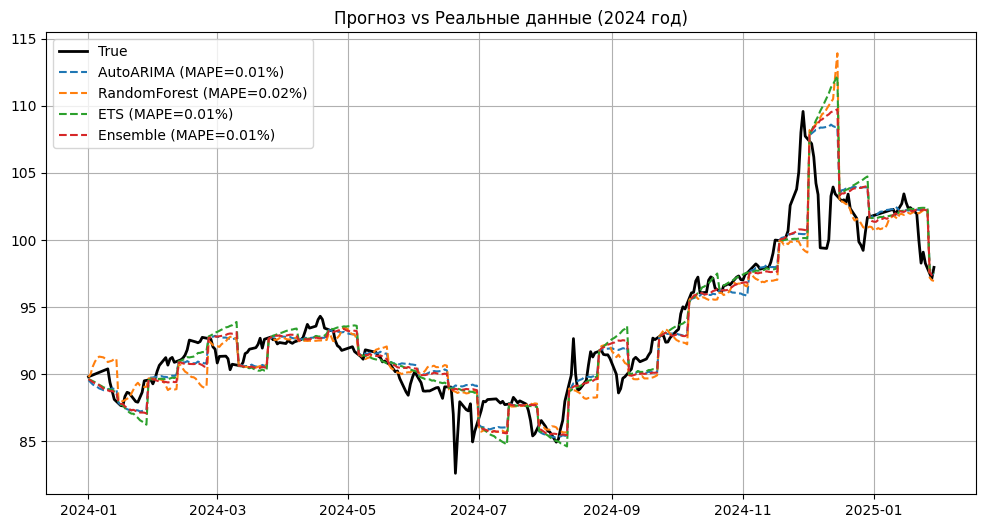

In [ ]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as mape
from sktime.forecasting.base import ForecastingHorizon
import matplotlib.pyplot as plt

results = {
    "name": [],
    "mape": [],
    "predictions": []
}

for name, model in models.items():
    y_pred = rolling_forecast(model, train_data, test_data, window_size=14)
    error = mape(test_data, y_pred)

    results["name"].append(name)
    results["mape"].append(error)
    results["predictions"].append(y_pred)

results_df = pd.DataFrame({
    "Model": results["name"],
    "MAPE": results["mape"]
}).sort_values("MAPE")

print(results_df)

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label="True", linewidth=2, color="black")

for i, name in enumerate(results["name"]):
    plt.plot(
        test_data.index,
        results["predictions"][i],
        "--",
        label=f"{name} (MAPE={results['mape'][i]:.2f}%)"
    )

plt.legend()
plt.title("Прогноз vs Реальные данные (2024 год)")
plt.grid()
plt.show()